In [60]:
import os
import gc
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

import spacy

from tqdm.auto import tqdm
tqdm.pandas()

import re
import string
import itertools
from collections import Counter

import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from tabulate import tabulate

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
file_path = '/kaggle/input/email-spam-detection-dataset-classification/spam.csv'

df = pd.read_csv(file_path, encoding='iso-8859-1')
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [62]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [63]:
df['sentiment'] = df['v1'].apply(lambda x: 1 if x == 'spam' else 0)


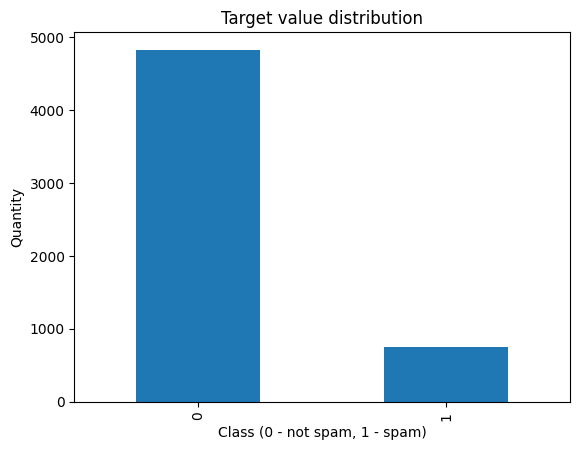

In [64]:
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Target value distribution')
plt.xlabel('Class (0 - not spam, 1 - spam)')
plt.ylabel('Quantity')
plt.show()


In [65]:
df.duplicated().sum()


403

In [66]:
df = df.drop_duplicates().reset_index(drop=True)


In [67]:
df.groupby(['v2']).count().sort_values('v1', ascending=False).head(10)

,v1,Unnamed: 2,Unnamed: 3,Unnamed: 4,sentiment
v2,,,,,
ÌÏ wait 4 me in sch i finish ard 5..,1,0,0,0,1
&lt;#&gt; in mca. But not conform.,1,0,0,0,1
&lt;#&gt; mins but i had to stop somewhere first.,1,0,0,0,1
&lt;DECIMAL&gt; m but its not a common car here so its better to buy from china or asia. Or if i find it less expensive. I.ll holla,1,0,0,0,1
and picking them up from various points,1,0,0,0,1
"came to look at the flat, seems ok, in his 50s? * Is away alot wiv work. Got woman coming at 6.30 too.",1,0,0,0,1
gonna let me know cos comes bak from holiday that day. is coming. Don't4get2text me number.,1,0,0,0,1
"said kiss, kiss, i can't do the sound effects! He is a gorgeous man isn't he! Kind of person who needs a smile to brighten his day!",1,0,0,0,1
"says that he's quitting at least5times a day so i wudn't take much notice of that. Nah, she didn't mind. Are you gonna see him again? Do you want to come to taunton tonight? U can tell me all about !",1,0,0,0,1


In [68]:
df.shape

(5169, 6)

In [69]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}


In [70]:
negations = {
    'aren',
    "aren't",
    'couldn',
    "couldn't",
    'didn',
    "didn't",
    'doesn',
    "doesn't",
    'don',
    "don't",
    'hadn',
    "hadn't",
    'hasn',
    "hasn't",
    'haven',
    "haven't",
    'isn',
    "isn't",
    'mightn',
    "mightn't",
    'mustn',
    "mustn't",
    'needn',
    "needn't",
    'no',
    'nor',
    'not',
    'shan',
    "shan't",
    'shouldn',
    "shouldn't",
    'wasn',
    "wasn't",
    'weren',
    "weren't",
    'won',
    "won't",
    'wouldn',
    "wouldn't"
}
stop_words = stop_words.difference(negations)


In [71]:
stemmer = PorterStemmer()


In [72]:
nlp = spacy.load("en_core_web_sm", disable = ['parser','ner'])


In [73]:
def normalize_text(raw_review):
    
    # Remove html tags
    text = re.sub("<[^>]*>", " ", raw_review) # match <> and everything in between. [^>] - match everything except >
    
    # Remove emails
    text = re.sub("\\S*@\\S*[\\s]+", " ", text) # match non-whitespace characters, @ and a whitespaces in the end
    
    # remove links
    text = re.sub("https?:\\/\\/.*?[\\s]+", " ", text) # match http, s - zero or once, //, 
                                                    # any char 0-unlimited, whitespaces in the end
        
     # Convert to lower case, split into individual words
    text = text.lower().split()
    
    # Replace contractions with their full versions
    text = [contractions.get(word) if word in contractions else word 
            for word in text]
   
    # Re-splitting for the correct stop-words extraction
    text = " ".join(text).split()    
    
    # Remove stop words
    text = [word for word in text if not word in stop_words]

    text = " ".join(text)
    
    # Remove non-letters        
    text = re.sub("[^a-zA-Z' ]", "", text) # match everything except letters and '

    # Stem words. Need to define porter stemmer above
    # text = [stemmer.stem(word) for word in text.split()]

    # Lemmatize words. Need to define lemmatizer above
    doc = nlp(text)
    text = " ".join([token.lemma_ for token in doc if len(token.lemma_) > 1 ])
    
    # Remove excesive whitespaces
    text = re.sub("[\\s]+", " ", text)    
    
    # Join the words back into one string separated by space, and return the result.
    return text

In [ ]:
df['text_normalized'] = df['v2'].progress_apply(normalize_text)

  0%|          | 0/5169 [00:00<?, ?it/s]

In [ ]:
train_idxs = df.sample(frac=0.8, random_state=42).index
test_idxs = [idx for idx in df.index if idx not in train_idxs]

X_train = df.loc[train_idxs, 'text_normalized']
X_test = df.loc[test_idxs, 'text_normalized']

y_train = df.loc[train_idxs, 'sentiment']
y_test = df.loc[test_idxs, 'sentiment']

In [ ]:
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)
len(vect.vocabulary_)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
len(vect.vocabulary_)

In [ ]:
word2vec_file_path = '/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_file_path, binary=True)


In [ ]:
# Creation the embedding function
def document_vector(doc):
    doc_words = doc.split()
    word_vectors = [word2vec_model[word] for word in doc_words if word in word2vec_model]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(300)

# Implementation the embedding function
X_train_emb = np.array([document_vector(doc) for doc in X_train])
X_test_emb = np.array([document_vector(doc) for doc in X_test])


In [ ]:
smote = SMOTE(random_state=42)

models = {
    'BoW_LogisticRegression': LogisticRegression(class_weight='balanced'),
    'TF-IDF_LogisticRegression': LogisticRegression(class_weight='balanced'),
    'Emb_LogisticRegressiong': LogisticRegression(class_weight='balanced')
}

results = {}

for model_name, model in models.items():
    if model_name == 'BoW_LogisticRegression':
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_bow, y_train)
        model.fit(X_train_balanced, y_train_balanced)
        preds = model.predict(X_test_bow)
        preds_proba = model.predict_proba(X_test_bow)[:, 1]
    elif model_name == 'TF-IDF_LogisticRegression':
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)
        model.fit(X_train_balanced, y_train_balanced)
        preds = model.predict(X_test_tfidf)
        preds_proba = model.predict_proba(X_test_tfidf)[:, 1]
    elif model_name == 'Emb_LogisticRegressiong':
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_emb, y_train)
        model.fit(X_train_balanced, y_train_balanced)
        preds = model.predict(X_test_emb)
        preds_proba = model.predict_proba(X_test_emb)[:, 1]
    
    accuracy = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, preds_proba)
    
    results[model_name] = {'Accuracy': accuracy, 'AUC': auc}


In [ ]:
# Creating the table for results
table = []
for model_name, metrics in results.items():
    table.append([model_name, metrics['Accuracy'], metrics['AUC']])

# Printing the results
print(tabulate(table, headers=['Model', 'Accuracy', 'AUC'], tablefmt='grid'))